<a href="https://colab.research.google.com/github/aoru45/FLAME_TO_HACK/blob/main/HACK_photo_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone Hack Repo

In [ ]:
!git clone https://github.com/ZoneLikeWonderland/HACK-Model.git
!mv HACK-Model/* ./

Cloning into 'HACK-Model'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Receiving objects: 100% (28/28), 47.38 MiB | 31.28 MiB/s, done.


Put your username and password to "**USERNAME_HERE**" and "**PASSWORD_HERE**",you shold register a username and password from [FLAME](https://flame.is.tue.mpg.de/) to get the dataset.

In [ ]:
!wget --post-data "username=USERNAME_HERE&password=PASSWORD_HERE" 'https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1' -O './TextureSpace.zip' --no-check-certificate --continue
!unzip TextureSpace.zip


--2023-08-25 13:01:19--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1
Resolving download.is.tue.mpg.de (download.is.tue.mpg.de)... 192.124.27.139
Connecting to download.is.tue.mpg.de (download.is.tue.mpg.de)|192.124.27.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: download.php?domain=flame&sfile=TextureSpace.zip&resume=1 [following]
--2023-08-25 13:01:20--  https://download.is.tue.mpg.de/download.php?domain=flame&sfile=TextureSpace.zip&resume=1
Reusing existing connection to download.is.tue.mpg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 1158570802 (1.1G) [application/octet-stream]
Saving to: ‘./TextureSpace.zip’

./TextureSpace.zip  100%[===================>]   1.08G  19.2MB/s    in 59s     

2023-08-25 13:02:19 (18.8 MB/s) - ‘./TextureSpace.zip’ saved [1158570802/1158570802]

Archive:  TextureSpace.zip
  inflating: FLAME_texture.npz       
  inflating: Readme.pdf              


In [ ]:
!pip install roma
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 13.2 MB/s eta 0:00:00


In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import os
import sys
import tqdm
import hack_model
import helper
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import knn_points, knn_gather
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
import pytorch3d
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import rasterize_meshes
from pytorch3d.renderer import TexturesUV
import trimesh
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.renderer import (look_at_view_transform,
                                FoVPerspectiveCameras,
                                FoVOrthographicCameras,
                                MeshRenderer,
                                MeshRasterizer,
                                RasterizationSettings,
                                SoftPhongShader,
                                HardPhongShader,
                                SoftGouraudShader,
                                HardGouraudShader,
                                TexturesVertex,
                                PointLights)
import torch
from tqdm.notebook import tqdm
device = torch.device("cuda")

In [2]:

hack = hack_model.HACK().to(device)
S = hack_model.load_pca(r"model/S.npy").to(device)
E = hack_model.load_pca(r"model/E.npy").to(device)
P = hack_model.load_pca(r"model/P.npy").to(device)



Prepare some landmarks.

In [3]:
# landmarks
hack_ldms_idx = [1225, 1888, 1052, 367, 1719, 1722, 2199, 1447, 966, 3661, 4390, 3927, 3924, 2608, 3272, 4088, 3443, 268, 493, 1914, 2044, 1401, 3615, 4240, 4114, 2734, 2509, 978, 4527, 4942, 4857, 1140, 2075, 1147, 4269, 3360, 1507, 1542, 1537, 1528, 1518, 1511, 3742, 3751, 3756, 3721, 3725, 3732, 5708, 5695, 2081, 0, 4275, 6200, 6213, 6346, 6461, 5518, 5957, 5841, 5702, 5711, 5533, 6216, 6207, 6470, 5517, 5966]
#hack_ldms_idx = hack_ldms_idx[17:]
hack_ldms_idx = torch.tensor(hack_ldms_idx, dtype = torch.long).to(device)
#img_ldms_2d = [[245.38943, 211.26398], [269.57996, 197.60037], [295.4558, 193.82367], [318.24268, 196.51138], [337.3947, 202.87022], [412.22418, 207.54408], [429.6233, 203.0567], [447.1845, 202.6347], [464.03345, 209.03802], [473.92792, 225.38214], [374.25403, 246.31627], [377.7384, 270.30182], [381.5866, 293.22797], [381.53552, 313.69403], [343.51666, 331.29837], [356.35852, 334.01434], [371.46155, 337.51767], [384.52917, 335.69672], [393.01215, 334.25125], [264, 252], [291, 241], [323, 237], [334, 251], [318, 252], [294, 249], [401, 255], [420, 244], [446, 242], [460, 255], [440, 258], [420, 255], [304.49982, 373.8486], [330.85962, 365.56885], [358.05634, 359.96518], [370.289, 363.06686], [381.90784, 361.638], [401.30487, 370.18536], [413.01947, 380.74606], [398.11597, 384.73773], [384.06335, 388.08438], [368.07056, 387.74844], [351.03943, 386.07706], [332.12646, 380.75378], [309.98633, 372.73206], [350.72882, 373.07513], [367.4126, 374.1097], [382.17096, 375.42905], [410.0326, 379.36578], [382.14105, 372.0839], [367.72522, 371.49854], [352.2655, 370.2742]]
#img_ldms_2d = [[176.32904, 257.52527], [178.68747, 299.19366], [184.75555, 337.54608], [191.78381, 371.07678], [205.379, 405.68008], [232.29558, 432.74957], [265.97778, 448.2917], [307.29224, 460.4441], [355.5973, 469.83963], [396.2002, 465.23923], [417.8819, 457.31302], [431.65576, 445.05817], [443.26233, 420.49036], [450.32837, 387.04514], [456.8291, 354.38968], [464.5569, 317.35516], [469.43268, 276.06476], [245.38943, 211.26398], [269.57996, 197.60037], [295.4558, 193.82367], [318.24268, 196.51138], [337.3947, 202.87022], [412.22418, 207.54408], [429.6233, 203.0567], [447.1845, 202.6347], [464.03345, 209.03802], [473.92792, 225.38214], [374.25403, 246.31627], [377.7384, 270.30182], [381.5866, 293.22797], [381.53552, 313.69403], [343.51666, 331.29837], [356.35852, 334.01434], [371.46155, 337.51767], [384.52917, 335.69672], [393.01215, 334.25125], [264, 252], [291, 241], [323, 237], [334, 251], [318, 252], [294, 249], [401, 255], [420, 244], [446, 242], [460, 255], [440, 258], [420, 255], [304.49982, 373.8486], [330.85962, 365.56885], [358.05634, 359.96518], [370.289, 363.06686], [381.90784, 361.638], [401.30487, 370.18536], [413.01947, 380.74606], [398.11597, 384.73773], [384.06335, 388.08438], [368.07056, 387.74844], [351.03943, 386.07706], [332.12646, 380.75378], [309.98633, 372.73206], [350.72882, 373.07513], [367.4126, 374.1097], [382.17096, 375.42905], [410.0326, 379.36578], [382.14105, 372.0839], [367.72522, 371.49854], [352.2655, 370.2742]]
img_ldms_2d_load = [[100.53144, 241.91693], [105.2054, 281.62628], [113.3316, 317.74493], [121.43477, 351.27313], [134.41621, 388.73383], [157.91103, 420.94012], [185.49971, 442.75464], [219.63766, 460.68542], [265.75308, 468.14758], [309.03577, 456.4519], [336.54364, 436.47986], [357.34555, 413.08875], [373.58224, 379.55316], [380.9747, 341.3376], [385.09213, 307.06982], [388.84003, 270.6316], [389.3672, 230.63956], [140.91248, 223.46855], [158.68806, 215.65242], [180.35225, 214.05914], [201.04556, 217.14508], [219.56935, 222.50986], [291.8489, 219.65154], [309.31775, 212.70837], [328.502, 208.00076], [348.49738, 207.88269], [363.89395, 214.55515], [257.98984, 256.84772], [260.16925, 282.82898], [262.62268, 308.94226], [263.8232, 329.43558], [236.1374, 338.61127], [247.52292, 342.31653], [262.2467, 345.46094], [276.14066, 341.1446], [286.16626, 336.52823], [170.3226, 251.9514], [183.70772, 247.19849], [201.10638, 246.31676], [217.37134, 252.85109], [203.0272, 258.25256], [184.37665, 258.98462], [292.09976, 249.95996], [308.44748, 241.84915], [325.9298, 240.63885], [338.55026, 245.5854], [326.0813, 253.2693], [307.7534, 254.3243], [202.6658, 376.47742], [225.22083, 371.9969], [250.7631, 368.1772], [263.46582, 370.36682], [275.63644, 367.3246], [299.4964, 369.28778], [317.93906, 371.82526], [297.54688, 383.74506], [281.07706, 390.95746], [263.74744, 392.8678], [246.13966, 392.55634], [227.90106, 386.8822], [207.53749, 375.28064], [245.94191, 377.99316], [263.08643, 378.34198], [279.76855, 376.9765], [314.7635, 371.16486], [278.39368, 376.18048], [262.46515, 377.7834], [246.29659, 377.38855]]

img_ldms_2d = torch.tensor(img_ldms_2d_load).to(device) / 500.

Prepare training image and training mask, you can download trump.png, msk.png from [FLAME_TO_HACK](https://github.com/aoru45/FLAME_TO_HACK). Then put them to the root folder. the msk.png is obtained by a skin segmentation network, you can use any method to obtain a skin mask.



In [4]:
import cv2 as cv
img = cv.imread("assets/trump.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_input = cv.resize(img, (256, 256), interpolation = cv.INTER_NEAREST)
img_input = img_input / 255.
img_target = torch.tensor(img_input).to(device)
img_mask = cv.imread("assets/msk.png", 0)
img_mask = cv.resize(img_mask, (500, 500))
# fill the eye mask
left_eye_idx = [36,37,38,39,40,41,36]
right_eye_idx = [42,43,44,45,46,47,42]

left_eye_poly = np.array([img_ldms_2d_load[idx] for idx in left_eye_idx]).astype(np.int32)
right_eye_poly = np.array([img_ldms_2d_load[idx] for idx in right_eye_idx]).astype(np.int32)
cv.fillConvexPoly(img_mask, left_eye_poly, 0)
cv.fillConvexPoly(img_mask, right_eye_poly, 0)
# cv.imwrite("tt.png", img_mask)
img_mask = cv.resize(img_mask, (256, 256))
img_mask = img_mask / 255.
img_mask = torch.tensor(img_mask).to(device)
m_ = img_mask < 0.5
img_mask[m_] = 0.
img_mask[~m_] = 1.


img_target = img_target.view(-1, 256, 256, 3)
img_mask = img_mask.view(-1, 256, 256, 1)

In [5]:
# flame_mesh, (flame_offset, flame_scale) = normalize_mesh(flame_mesh)
beta = torch.nn.Parameter(torch.randn(1,200).to(device))
theta = torch.nn.Parameter(torch.zeros(1, 8, 3).to(device))
tau = torch.nn.Parameter(torch.zeros(1,1).to(device))
alpha = torch.nn.Parameter(torch.ones(1, 1).to(device))
bsw = torch.nn.Parameter(torch.zeros(1, 55).to(device))
camera = torch.nn.Parameter(torch.tensor([[12,19,0.1]]).to(device))
lights = torch.nn.Parameter(torch.zeros(1, 9, 3).float().to(device))
tex_code = torch.nn.Parameter(torch.zeros(1,50).to(device))

# optimizer_camera = torch.optim.Adam([theta, camera], lr = 5e-3, weight_decay = 5e-4)
optimizer_camera = torch.optim.AdamW([beta, camera, theta], lr=5e-3, amsgrad=True)
num_camera_optim_iter = 2000


Train form some epochs. It is used to fit the camera parameters and pose parameters using 2d landmarks.

In [6]:
cam_loop = tqdm(range(num_camera_optim_iter))

for _iter in cam_loop:
    optimizer_camera.zero_grad()
    # (B,N,3)
    pred_verts = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"]

    # camera
    pred_verts[..., 0] += camera[0,0]
    pred_verts[..., 1] += camera[0,1]
    pred_verts = pred_verts * camera[0, 2]

    pred_verts_2d = pred_verts[..., :2]
    target_ldms_2d = img_ldms_2d.clone()
    target_ldms_2d[:, 1] = 1 - target_ldms_2d[:, 1]

    # ldm
    pred_ldms_2d = torch.index_select(pred_verts_2d[0], 0, hack_ldms_idx)
    loss_ldm = torch.nn.functional.mse_loss(pred_ldms_2d, target_ldms_2d)
    # loss_laplacian = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
    loss = loss_ldm

    cam_loop.set_description(f"[Loss: {loss:.6f}]")
    loss.backward()
    optimizer_camera.step()



  # plot_mesh2(flame_mesh, deformed_mesh, f"{epoch}")


  0%|          | 0/2000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

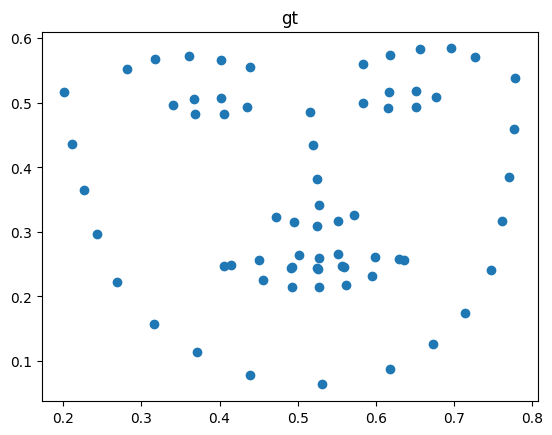

<Figure size 640x480 with 0 Axes>

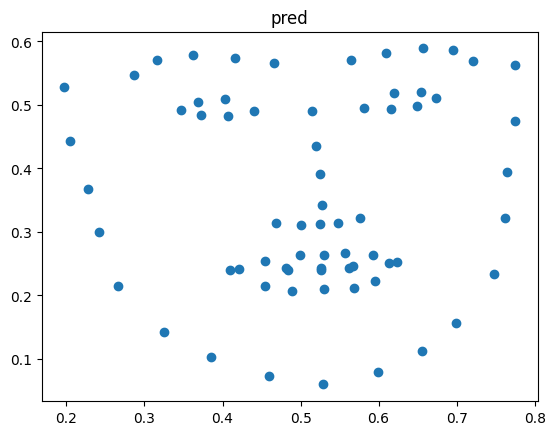

In [8]:
plt.figure(1)
pts_ = img_ldms_2d.clone().cpu().numpy()
x = pts_[:, 0]
y = pts_[:, 1]
plt.figure()
plt.scatter(x, 1-y)
plt.title("gt")
plt.show()

plt.figure(2)
pts_ = pred_ldms_2d.detach().clone().cpu().numpy()
# pts_ = img_ldms_2d.clone().cpu().numpy()
x = pts_[:, 0]
y = pts_[:, 1]
plt.figure()
plt.scatter(x, y)
plt.title("pred")
plt.show()


You should download hack_modified_template.obj and put them in root folder. You can download it from [FLAME_TO_HACK](https://github.com/aoru45/FLAME_TO_HACK)



In [7]:
verts_, o_faces, aux = load_obj("assets/hack_w_flame.obj")
# verts = verts[None, ...] # (N, V, 3)

vts = aux.verts_uvs[None, ...].to(device)  # (N, V, 2)
fvts = o_faces.textures_idx[None, ...].to(device)  # (N, F, 3)
faces = o_faces.verts_idx[None, ...].to(device) # (N,F,3)
class HACKTex(torch.nn.Module):
    def __init__(self):
        super().__init__()
        tex_params = 50

        tex_space = np.load("FLAME_texture.npz")
        texture_mean = tex_space['mean'].reshape(1, -1)
        texture_basis = tex_space['tex_dir'].reshape(-1, 200)
        num_components = texture_basis.shape[1]
        texture_mean = torch.from_numpy(texture_mean).float()[None,...]
        texture_basis = torch.from_numpy(texture_basis[:,:tex_params]).float()[None,...]

        self.register_buffer('texture_mean', texture_mean)
        self.register_buffer('texture_basis', texture_basis)

    def forward(self, texcode):
        texture = self.texture_mean + (self.texture_basis*texcode[:,None,:]).sum(-1)
        texture = texture.reshape(texcode.shape[0], 512, 512, 3).permute(0,3,1,2)
        texture = torch.nn.functional.interpolate(texture, [256, 256])
        texture = texture[:,[2,1,0], :,:] / 255.
        return texture
hack_tex_generator = HACKTex().to(device)


Render function

In [8]:
pi = np.pi
constant_factor = torch.tensor(
            [1 / np.sqrt(4 * pi), ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))), ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))), \
             ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))), (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
             (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))), \
             (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))), (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
             (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi)))]).to(device)
def add_SHlight(normal_images, sh_coeff):
    '''
    sh_coeff: [bz, 9, 3]
    '''

    N = normal_images
    sh = torch.stack([
      N[:, 0] * 0. + 1., N[:, 0], N[:, 1], \
      N[:, 2], N[:, 0] * N[:, 1], N[:, 0] * N[:, 2],
      N[:, 1] * N[:, 2], N[:, 0] ** 2 - N[:, 1] ** 2, 3 * (N[:, 2] ** 2) - 1
  ],
      1)  # [bz, 9, h, w]
    sh = sh * constant_factor[None, :, None, None]
    shading = torch.sum(sh_coeff[:, :, :, None, None] * sh[:, :, None, :, :], 1)  # [bz, 9, 3, h, w]
    return shading
def render_mesh(mesh, uv_vertices, uv_faces, uv_image, light, image_size = 256):
    # vertices (B, V, 3)
    # faces (B, F, 3)

    vertices = mesh.verts_padded()
    faces = mesh.faces_padded()
    normals = mesh.verts_normals_padded().detach()

    fixed_vertices = vertices.clone()
    fixed_vertices[..., 0] = -2*fixed_vertices[..., 0] + 1
    fixed_vertices[..., 1] = 2*fixed_vertices[..., 1] - 1
    fixed_vertices[..., 2] = -fixed_vertices[..., 2] + 10

    meshes_screen = Meshes(verts=fixed_vertices, faces=faces)
    pix_to_face, zbuf, bary_coords, dists = rasterize_meshes(
      meshes_screen,
      image_size=image_size,
      blur_radius=0,
      faces_per_pixel=1,
      bin_size=None,
      max_faces_per_bin=None
    )

    vismask = (pix_to_face > -1).float()
    mask = pix_to_face == -1
    # pix_to_face: (N, image_size, image_size, 1)
    pix_to_face = pix_to_face.clone()
    pix_to_face[mask] = 0
    # torch.Size([262144, 3])
    idx = pix_to_face.flatten()

    pixel_face_idx = torch.index_select(faces.view(-1,3),0, idx) #(n, 3)
    uv_face_idx = torch.index_select(uv_faces.view(-1,3), 0, idx)

    # uv coordinatex
    p1 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 0]) #(n,2)
    p2 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 1]) #(n,2)
    p3 = torch.index_select(uv_vertices[0], 0, uv_face_idx[:, 2]) #(n,2)

    # normals
    n1 = torch.index_select(normals[0], 0, pixel_face_idx[:, 0]) #(n,2)
    n2 = torch.index_select(normals[0], 0, pixel_face_idx[:, 1]) #(n,2)
    n3 = torch.index_select(normals[0], 0, pixel_face_idx[:, 2]) #(n,2)

    p = torch.stack([p1, p2, p3], dim = 1)
    n = torch.stack([n1, n2, n3], dim = 1)

    p_interp = (p * bary_coords.view(-1,3,1)).sum(1) # (n, 2)
    n_interp = (n * bary_coords.view(-1,3,1)).sum(1).view(-1, image_size, image_size, 3).permute(0,3,1,2)

    grid = p_interp.view(-1, image_size, image_size, 2)
    grid = grid * 2 - 1
    grid[...,1] = -grid[..., 1]

    output = torch.nn.functional.grid_sample(uv_image,
                                           grid,
                                           mode='bilinear',
                                           padding_mode="border",
                                           align_corners=False)
    # output (n, c, h ,w)
    shade = add_SHlight(n_interp, light)

    return (output * shade).permute(0, 2, 3, 1), vismask


Optimize for some iterations.

In [10]:
# optimizer_photo = torch.optim.AdamW([beta, theta, tau, bsw,alpha, camera, lights, tex_code], lr=5e-2, amsgrad=True)

optimizer_photo = torch.optim.Adam([
             {'params': [beta, lights, tex_code], "lr": 1e-3},
             {'params': [camera, theta, tau], 'lr': 1e-6},
             {'params': [bsw], 'lr': 1e-6}
        ],
         lr=1e-3
 )


#optimizer_photo = torch.optim.Adam([beta, theta, tau, bsw, camera, lights, tex_code], lr=1e-4)
num_photo_optim_iter  = 5000
photo_loop = tqdm(range(num_photo_optim_iter))
# optimize photo with render
for _iter in photo_loop:
    optimizer_photo.zero_grad()
    pred_verts = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"]
    # camera transform
    pred_verts[..., 0] += camera[0,0]
    pred_verts[..., 1] += camera[0,1]
    pred_verts = pred_verts * camera[0, 2]

    # to image space
    pred_verts_2d = pred_verts[..., :2]
    target_ldms_2d = img_ldms_2d.clone()
    target_ldms_2d[:, 1] = 1 - target_ldms_2d[:, 1]

    # ldm
    pred_ldms_2d = torch.index_select(pred_verts_2d[0], 0, hack_ldms_idx)


    # render
    pred_uv_map = hack_tex_generator(tex_code)
    mesh = Meshes(verts = pred_verts, faces = faces)
    rendered_image, vismask = render_mesh(mesh, vts, fvts, pred_uv_map, lights)
    loss_ldm = torch.nn.functional.mse_loss(pred_ldms_2d, target_ldms_2d)

    loss_photo = (img_mask.detach() * (rendered_image - img_target).abs()).mean()
    loss_regularization = (torch.sum(beta ** 2) / 2) * 1e-4 + (torch.sum(bsw ** 2) / 2) * 1e-2
    loss = 1 * loss_ldm + loss_photo  + loss_regularization
    photo_loop.set_description(f"[Loss: {loss:.6f}] [ldm: {loss_ldm:.6f}] [photo: {loss_photo:.6f}]")

    loss.backward()
    optimizer_photo.step()




  0%|          | 0/5000 [00:00<?, ?it/s]

Draw the optimization result and render it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


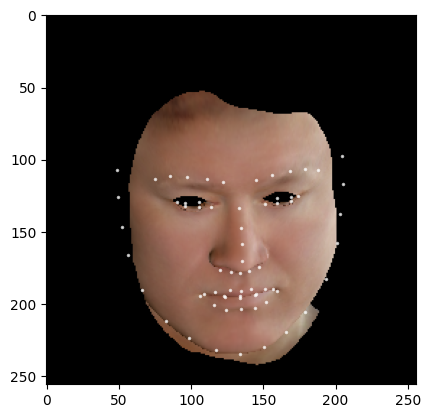

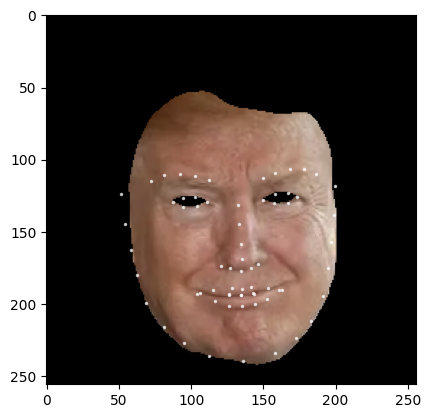

In [11]:
with torch.no_grad():
    pred_verts = hack(theta, tau, alpha, bsw, T=S(beta), E=E(), P=P())["T_transformed"]
    # camera transform
    pred_verts[..., 0] += camera[0,0]
    pred_verts[..., 1] += camera[0,1]
    pred_verts = pred_verts * camera[0, 2]

    # to image space
    pred_verts_2d = pred_verts[..., :2]
    pred_ldms_2d = torch.index_select(pred_verts_2d[0], 0, hack_ldms_idx)


    # render
    pred_uv_map = hack_tex_generator(tex_code)
    mesh = Meshes(verts = pred_verts, faces = faces)
    rendered_image, vismask = render_mesh(mesh, vts, fvts, pred_uv_map, lights)
    img_to_show = (rendered_image.detach() * img_mask.detach()).cpu()[0].numpy()

    pred_ldms_2d_ = pred_ldms_2d.detach().cpu().numpy()
    pred_ldms_2d_[:, 1] = 1 - pred_ldms_2d_[:, 1]
    pred_ldms_2d_ = pred_ldms_2d_ * 256
    plt.figure(1)
    plt.imshow(img_to_show)
    plt.scatter(pred_ldms_2d_[:, 0], pred_ldms_2d_[:, 1], color='w', lw=1.5, alpha=0.7,s=1)
    plt.show()
    plt.figure(2)
    plt.imshow((img_target*img_mask)[0].cpu().numpy())
    img_ldms_2d_ =img_ldms_2d.detach().cpu().numpy() * 256
    plt.scatter(img_ldms_2d_[:, 0], img_ldms_2d_[:, 1], color='w', lw=1.5, alpha=0.7,s=1)
    plt.show()
